In [1]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression
from statistics import mean
from sklearn.metrics import f1_score,roc_auc_score,confusion_matrix
import seaborn as sns

pd.options.display.max_seq_items = None

In [3]:
from google.colab import files
uploaded = files.upload()

Saving full_data.csv to full_data.csv


In [14]:
import io
df = pd.read_csv(io.BytesIO(uploaded['full_data.csv']))
df.drop(df.columns[0], axis=1, inplace=True)
df.head()

,Cancer Type Detailed,Mutation Count,Fraction Genome Altered,Diagnosis Age,Sex,Somatic Status,Smoking History,Person Cigarette Smoking History Pack Year Value,TMB Nonsynonymous
0,Lung Adenocarcinoma,3.0,0.1539,56.0,Female,Matched,Former Smoker,36.427867,0.066667
1,Lung Adenocarcinoma,32.0,0.1318,56.0,Female,Matched,Former Smoker,36.427867,1.066667
2,Lung Adenocarcinoma,370.0,0.3385,69.0,Male,Matched,Former Smoker,36.427867,12.466667
3,Lung Adenocarcinoma,72.0,0.0758,69.0,Female,Matched,Former Smoker,36.427867,2.400000
4,Lung Adenocarcinoma,652.0,0.3153,78.0,Male,Matched,Former Smoker,36.427867,21.800000


In [18]:
# Split the dataset into train and test sets
X = df.loc[:, df.columns != 'Cancer Type Detailed']
y = df['Cancer Type Detailed']
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size = 0.2, random_state = 11)
X_train.shape

(4056, 8)

In [19]:
# Define the data preparation for the columns
numerical_ix = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_ix = X_train.select_dtypes(include=['object']).columns
# Define categorical pipeline
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

# Define numerical pipeline
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Define columntransformer 

transformer = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_ix),
        ('cat', categorical_transformer, categorical_ix)
])

In [20]:
# Change your model here
logistic_pipline= imbpipeline([
    ('smote',SMOTENC(categorical_features = [3,4,5],random_state = 11)),
    ('transformer', transformer),
    ('model', LogisticRegression(penalty ='none', solver='saga'))
])

In [21]:
logistic_pipline.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Pipeline(steps=[('smote',
                 SMOTENC(categorical_features=[3, 4, 5], random_state=11)),
                ('transformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Mutation Count', 'Fraction Genome Altered', 'Diagnosis Age',
       'Person Cigarette Smoking History Pack Year Value',
       'TMB Nonsynonymous'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missi

In [22]:
# Accuracy
logistic_pipline.score(X_test, y_test)

0.7694581280788177

In [ ]:
# f1 score
preds = logistic_pipline.predict(X_test)
f1_score(y_test, preds, average = "weighted")

0.802816471281084

<AxesSubplot:>

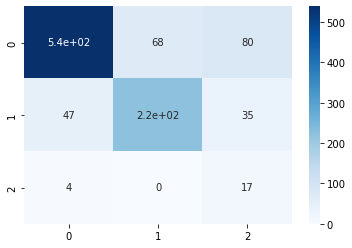

In [ ]:
# confusion matrix
cf_matrix = confusion_matrix(y_test,preds)
sns.heatmap(cf_matrix, annot = True, cmap = "Blues")

In [28]:
preprocessor=transformer.fit(X_train)
def preprocess(data):
    preprocessed_data=preprocessor.transform(data)
    return preprocessed_data
preprocess(X_train)

array([[ 0.09048504,  1.06405617, -0.16636691, ...,  0.        ,
         0.        ,  1.        ],
       [-0.80642865, -0.83752041, -0.08891538, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.40245501, -1.00496799, -0.8862745 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.23015077,  0.62607609, -1.6061821 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.51077792,  0.24827249, -1.3662129 , ...,  0.        ,
         0.        ,  1.        ],
       [-0.81942739, -0.0491152 , -0.08891538, ...,  1.        ,
         0.        ,  0.        ]])

In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {'n_estimators': [100, 120, 150],
           'criterion': ['entropy', 'gini'], 
           'max_depth': [1,3,5,7,9],
           'max_features': range(1,3)}
RF = GridSearchCV(RandomForestClassifier(),param_grid, cv = 5,n_jobs=-1)

RF.fit(preprocess(X_train), y_train)

print("Random Forest Classifier:\nbest parameters: {}".format(RF.best_params_))
print("cross-validation score: {:.3f}".format(RF.best_score_))
print("test-set score: {:.3f}".format(RF.score(preprocess(X_test), y_test)))

Random Forest Classifier:
best parameters: {'criterion': 'entropy', 'max_depth': 9, 'max_features': 2, 'n_estimators': 100}
cross-validation score: 0.893
test-set score: 0.887


In [37]:
from sklearn.svm import SVC
param_grid = {'C': [0.1,1,10,100],'degree':[1,2,3,4,5,6],
 'gamma': [1,0.1,0.01,0.001,0.0001],'kernel': ['rbf', 'poly', 'sigmoid']}

SVM = GridSearchCV(SVC(),param_grid, cv = 5,n_jobs=-1,verbose=False)

SVM.fit(preprocess(X_train), y_train)

print("SVM Classifier:\nbest parameters: {}".format(SVM.best_params_))
print("cross-validation score:{:.3f}".format(SVM.best_score_))
print("test-set score: {:.3f}".format(SVM.score(preprocess(X_test), y_test)))

SVM Classifier:
best parameters: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
cross-validation score:0.865
test-set score: 0.866


In [34]:
from sklearn.neighbors import KNeighborsClassifier
param_grid = {'weights': ['uniform', 'distance'],'n_neighbors': np.arange(1, 15, 2)} 

KNN = GridSearchCV(KNeighborsClassifier(),param_grid, cv = 10)

KNN.fit(preprocess(X_train), y_train)

print("KNN Classifier:\nbest parameters: {}".format(KNN.best_params_))
print("cross-validation score:{:.3f}".format(KNN.best_score_))
print("test-set score: {:.3f}".format(KNN.score(preprocess(X_test), y_test)))

KNN Classifier:
best parameters: {'n_neighbors': 9, 'weights': 'distance'}
cross-validation score:0.877
test-set score: 0.866


In [40]:

param_grid =[{"C":np.logspace(-4,3,6),'penalty': ['l1'], 'solver': [ 'liblinear', 'saga']},
  {"C":np.logspace(-4,3,6),'penalty': ['l2'], 'solver': ['newton-cg','lbfgs','sag']},
  {"C":np.logspace(-4,3,6),'penalty': ['elasticnet'], 'solver': ['saga'],'l1_ratio':np.arange(0, 1, 0.2)}]

LR=GridSearchCV(LogisticRegression(verbose=False, max_iter=5000),
                     param_grid,scoring = 'accuracy',n_jobs = -1,cv = 10)
LR.fit(preprocess(X_train), y_train)


print("Logistic Regression:\nbest parameters: {}".format(LR.best_params_))
print("cross-validation score:{:.3f}".format(LR.best_score_))
print("test-set score: {:.3f}".format(LR.score(preprocess(X_test), y_test)))

Logistic Regression:
best parameters: {'C': 39.81071705534969, 'penalty': 'l1', 'solver': 'saga'}
cross-validation score:0.843
test-set score: 0.830


In [43]:
from sklearn.metrics import precision_recall_fscore_support as score

y_pred_RF=RF.predict(preprocess(X_test))
y_pred_SVM=SVM.predict(preprocess(X_test))
y_pred_KNN=KNN.predict(preprocess(X_test))
y_pred_LR=LR.predict(preprocess(X_test))


data = {'Logistic Regression':score(y_test,y_pred_LR,pos_label=1)+(LR.score(preprocess(X_test), y_test),), 
                 'KNN':score(y_test,y_pred_KNN,pos_label=1)+(KNN.score(preprocess(X_test), y_test),), 
                 'Random Forest':score(y_test,y_pred_RF,pos_label=1)+(RF.score(preprocess(X_test), y_test),), 
                 'Support Vector Classifier':score(y_test,y_pred_SVM,pos_label=1)+(SVM.score(preprocess(X_test), y_test),)} 
report=pd.DataFrame.from_dict(data,orient='index',columns=['precision', 'recall', 'f1-score', 'support','accuracy'])
report['error']=1-report['accuracy']
report[['precision', 'recall', 'f1-score', 'accuracy','error']]

,precision,recall,f1-score,accuracy,error
Logistic Regression,"[0.87, 0.7388535031847133, 1.0]","[0.8864628820960698, 0.755700325732899, 0.0476...","[0.8781542898341744, 0.7471819645732689, 0.090...",0.829557,0.170443
KNN,"[0.9191616766467066, 0.7777777777777778, 0.428...","[0.893740902474527, 0.8436482084690554, 0.2857...","[0.9062730627306275, 0.8093750000000001, 0.342...",0.866010,0.133990
Random Forest,"[0.9098712446351931, 0.8349514563106796, 0.857...","[0.925764192139738, 0.8403908794788274, 0.2857...","[0.9177489177489176, 0.8376623376623378, 0.428...",0.886700,0.113300
Support Vector Classifier,"[0.8971428571428571, 0.8006535947712419, 0.666...","[0.9141193595342066, 0.7980456026058632, 0.285...","[0.905551550108147, 0.799347471451876, 0.4]",0.866010,0.133990
